Forward search started at: 2024-04-22 11:42:58.689326
Forward search ended at: 2024-04-22 11:42:58.690571
0:00:00.000800
Backwards search started at: 2024-04-22 11:42:58.691045
Backwards search ended at: 2024-04-22 11:42:58.691562
0:00:00.000502
Search started at: 2024-04-22 11:42:58.691960
Search ended at: 2024-04-22 11:42:58.692085
40996864
Total execution time: 0.027782917022705078 seconds
Results: {'1001': 1024}


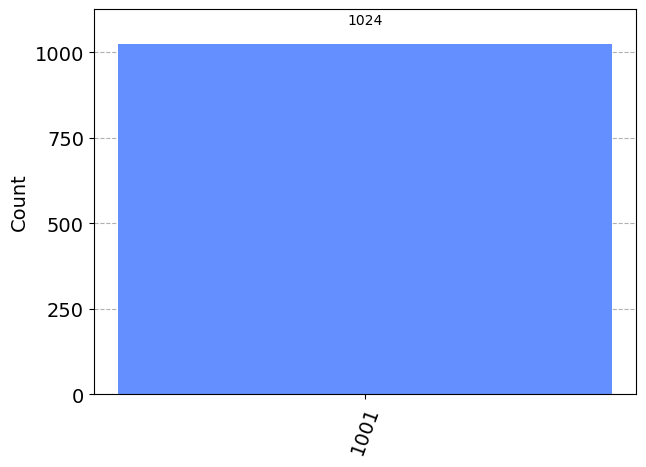

In [3]:
from qiskit import QuantumCircuit, Aer, execute, transpile
import time
import threading
from qiskit.visualization import plot_histogram
from datetime import datetime
from multiprocessing import Pool
import psutil


# Define the necessary functions for the Grover search
def partial_hadamard_transform(circuit, qubits_to_superpose):
    for qubit in qubits_to_superpose:
        circuit.h(qubit)

def UI(circuit, qubits, ancilla, found_solutions):
    for solution in found_solutions:
        for i, bit in enumerate(solution):
            if bit == '0':
                circuit.x(qubits[i])
        circuit.mcx(qubits, ancilla)
        for i, bit in enumerate(solution):
            if bit == '0':
                circuit.x(qubits[i])

def partial_oracle(circuit, qubits, ancilla, target_state):
    for qubit, bit in zip(qubits, target_state):
        if bit == '0':
            circuit.x(qubit)
    circuit.mcx(qubits, ancilla)
    for qubit, bit in zip(qubits, target_state):
        if bit == '0':
            circuit.x(qubit)
            

def partial_diffuser(circuit, qubits_pair):
    for qubit in qubits_pair:
        circuit.h(qubit)
        circuit.x(qubit)
    circuit.h(qubits_pair[-1])
    circuit.mcx(qubits_pair[:-1], qubits_pair[-1])
    circuit.h(qubits_pair[-1])
    for qubit in qubits_pair:
        circuit.x(qubit)
        circuit.h(qubit)

def apply_grover_to_segment_forward(circuit, start_qubit, mid_qubit, solution, ancilla):
    print(f"Forward search started at: {datetime.now()}")
    time1 = datetime.now()
    found_solutions = []
    for step in range(0, mid_qubit - start_qubit, 2):
        qubits_to_superpose = list(range(start_qubit + step, min(start_qubit + step + 2, mid_qubit)))

        partial_hadamard_transform(circuit, qubits_to_superpose)
        if found_solutions:
            UI(circuit, qubits_to_superpose, ancilla, found_solutions)
        partial_oracle(circuit, qubits_to_superpose, ancilla, solution[step:step + 2])
        partial_diffuser(circuit, qubits_to_superpose)

    time2 = datetime.now()
    print(f"Forward search ended at: {datetime.now()}")
    print(time2-time1)
    

def apply_grover_to_segment_backward(circuit, start_qubit, end_qubit, solution, ancilla2):
    print(f"Backwards search started at: {datetime.now()}")
    time1 = datetime.now()
    found_solutions = []
    # The backward search will operate on the second half of the qubits
    for step in range(0, end_qubit - start_qubit, 2):
        qubits_to_superpose = list(range(start_qubit + step, min(start_qubit + step + 2, end_qubit)))

        partial_hadamard_transform(circuit, qubits_to_superpose)
        if found_solutions:
            UI(circuit, qubits_to_superpose, ancilla2, found_solutions)

        # Use the corresponding segment of the solution string as is
        target_state = solution[start_qubit + step : start_qubit + step + 2]
        partial_oracle(circuit, qubits_to_superpose, ancilla2, target_state)
        partial_diffuser(circuit, qubits_to_superpose)
       
    time2 = datetime.now()
    print(f"Backwards search ended at: {datetime.now()}")
    print(time2-time1)

        
def run_concurrent_grover_search():
    n = 4
    circuit = QuantumCircuit(n + 2, n)  
    solution = '1001'  # Example solution
    ancilla = n
    ancilla2 = n + 1
    circuit.x(ancilla)
    circuit.h(ancilla)
    circuit.x(ancilla2)
    circuit.h(ancilla2)
    mid_qubit = n // 2

    
    # Start threads for parallel-like execution
    thread_first_half = threading.Thread(target=apply_grover_to_segment_forward, args=(circuit, 0, mid_qubit, solution, ancilla))
    thread_second_half = threading.Thread(target=apply_grover_to_segment_backward, args=(circuit, mid_qubit, n, solution, ancilla2))

    thread_first_half.start()
    thread_second_half.start()

    thread_first_half.join()
    thread_second_half.join()
   
    #print(f"Search started at: {datetime.now()}")
    #apply_grover_to_segment_forward(circuit, 0, mid_qubit, solution, ancilla)
    #apply_grover_to_segment_backward(circuit, mid_qubit, n, solution, ancilla)
    
    # Measure all qubits at the end
    
    print(f"Search started at: {datetime.now()}")
    circuit.measure(range(n), range(n))
    
    
    print(f"Search ended at: {datetime.now()}")

    # Run the circuit
    backend = Aer.get_backend('aer_simulator')
    transpiled_circuit = transpile(circuit, backend)
    result = execute(transpiled_circuit, backend).result()
    counts = result.get_counts()
    #print(circuit)

    return counts

# Run the concurrent Grover search
start_time = time.time()
counts = run_concurrent_grover_search()
end_time = time.time()

process = psutil.Process()
print(process.memory_info().rss)

print(f"Total execution time: {end_time - start_time} seconds")
print(f"Results: {counts}")
plot_histogram(counts) 